In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tune_sklearn import TuneGridSearchCV
from sklearn import preprocessing
import sys
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn import metrics
import json
import multiprocessing



FORCE_RANDOM_Y = False
DO_SHAPLY = True
OUTPUT_DIR = "./output/"
DATASETS_DIR = "../datasets/"


def get_data(params):
    global df
    global df_text
    
    print("1/4 Loading post texts started")
    df_text = pd.read_csv(DATASETS_DIR+"id_to_text.csv")
    
    
    
    prepend_csv = "prepend_done.csv"
    standalone_csv = "standalone_done.csv"

    print("2/4 Loading post features started")
    if params["title_prepend"]:
        df = load_wo_cols(DATASETS_DIR+prepend_csv, params)
    else:
        df = load_wo_cols(DATASETS_DIR+standalone_csv, params)

    
    #print("Done loading features")
    if params["new_reactions"]:
        new_react = "id_to_reactions_new.csv"
        df_reactions = pd.read_csv(DATASETS_DIR+new_react)
        df = df.merge(df_reactions, left_on="post_id", right_on="post_id",
                      validate="1:1", suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

    if params["norm"] < 2:
        df = df[df.columns.drop(
            list(df.filter(regex="_abs" if params["norm"] == 1 else "_norm")))]

    keys = ["info", "yta", "nah", "esh", "nta"]
    weight = "weighted_" if params["weighted"] else ""
    values = ["reactions_"+weight+k.upper() for k in keys]
    acros = dict(zip(keys, values))

    dfs = []
    if params["topics_separate"] > 0:

        topic_min = df["topic_nr"].min()
        topic_max = df["topic_nr"].max()
        #print(f"Data split by topic ({topic_min}, {topic_max})")

        for i in range(topic_min, topic_max+1):
            dfs.append(df.loc[df["topic_nr"] == i])
    else:
        dfs = [df]


    return dfs, acros


def load_wo_cols(path, params, remove_cols=[], verbose=False):
    cols_to_remove = ["post_text", "Unnamed: 0", "Unnamed: 1", "Unnamed: 2", "Unnamed: 0.1",
                      "Unnamed: 0.1.1", "liwc_post_id", "foundations_post_id",
                      "foundations_title_post_id", "liwc_title_post_id", "post_created_utc"]+remove_cols
    metadata = ["speaker_account_comment_karma", "post_num_comments", "speaker_account_age",
                "speaker_account_link_karma", "post_ups", "post_downs", "post_score", "reactions_is_devil", "reactions_is_angel","post_ratio"]
    # removed "post_ratio" from metadata b.c. used for weights

    removed = []
    df = pd.read_csv(path, nrows=10)
    cols_to_read = list(df.columns)

    # remove metadata
    if params["wo_metadata"]:
        cols_to_remove = cols_to_remove+metadata

    if params["new_reactions"]:
        cols_to_remove = cols_to_remove + \
            list(filter(lambda x: "reaction" in x and not "reaction_is" in x, cols_to_read))

    # remove liwc
    if not params["use_liwc"]:
        cols_to_remove = cols_to_remove + \
            list(filter(lambda x: "liwc_" in x, cols_to_read))

    # remove moral foundations
    if not params["use_mf"]:
        cols_to_remove = cols_to_remove + \
            list(filter(lambda x: "foundations_" in x, cols_to_read))

    # post requirements setup
    cols_to_remove = [
        x for x in cols_to_remove if x not in list(params["requirements"].keys())]

    if verbose:
        print(cols_to_read)
    for col in cols_to_remove:
        if col in cols_to_read:
            cols_to_read.remove(col)
            removed.append(col)

    #print(f"Removed {removed} from {path.split('/')[-1]}")
    #print("ONLY USING 10k lines")
    df = pd.read_csv(path, usecols=cols_to_read,)

    # delte posts that don't meet requirements
    nr_rows_pre_req = len(df)
    for k, v in params["requirements"].items():
        df = df.loc[(df[k] >= v), :]
    # remove cols required for "requirements"
    if params["wo_metadata"]:
        to_drop = set(list(params["requirements"].keys()))
        in_list = set(list(df.columns))
        will_drop = list(to_drop.intersection(in_list))
        df = df.drop(columns=will_drop)
        removed += will_drop
        
        
    
    # print(
    #    f"Removed {int(100*(nr_rows_pre_req-len(df))/len(df))}% due to requirements, Now {len(df)} posts remain.")
    # Check values in df
    # df.describe().loc[['min','max']].to_csv("min_max.csv",index=False)
    return df


def sampling(X_train, y_train, params, indices=[], verbose=False):
    df_len_old = len(X_train)
    if verbose:
        print(f"{params['sampling']}-sampling for {params['predict']}")

    if params["sampling"] == "none":
        X_train_ret = X_train
        y_train_ret = y_train

    if verbose:
        print("Original Y distribution on training set")
        _ = plt.hist(y_train, bins='auto')
        plt.show()

    if params["predict"] == "ratio":
        if params["sampling"] == "up":
            raise Exception("Upsampling with regression is not feasible☹️")
        elif params["sampling"] == "down":
            # downsampling
            bucket_ranges = [x/10 for x in list(range(0, 11))]
            bucket_counter = []

            X_train_tmp = X_train
            y_train_tmp = y_train.reshape((len(y_train), 1))
            dummy_feat_name = [str(int) for int in range(X_train_tmp.shape[1])]
            feat_names_to_sample = dummy_feat_name+["Y"]
            data_to_sample = np.append(X_train_tmp, y_train_tmp, 1)
            df_to_sample = pd.DataFrame(
                data_to_sample, columns=feat_names_to_sample)

            # Get bucket sizes
            for i in range(len(bucket_ranges)):
                if bucket_ranges[i] == 1:
                    continue
                orig_size = len(df_to_sample.loc[(bucket_ranges[i] <= df_to_sample['Y']) & (
                    df_to_sample['Y'] <= bucket_ranges[i+1])])
                bucket_counter.append(orig_size)

            # We only downsample buckets that are > 2* bucket mean => 2*bucket mean
            bucket_max = int(np.mean(bucket_counter)*1.5)
            for j in range(len(bucket_counter)):
                if bucket_counter[j] > bucket_max:
                    if verbose:
                        print(
                            f"Bucket {bucket_ranges[j]}-{bucket_ranges[j+1]} has {bucket_counter[j]}>{bucket_max}")
                    df_bkt = df_to_sample.loc[(bucket_ranges[j] <= df_to_sample['Y']) & (
                        df_to_sample['Y'] <= bucket_ranges[j+1])]
                    df_bkt_smpl = df_bkt.sample(
                        n=max(int(bucket_max),len(df_bkt)), replace=False, random_state=42)
                    df_to_sample.loc[(bucket_ranges[j] <= df_to_sample['Y']) & (
                        df_to_sample['Y'] <= bucket_ranges[j+1])] = df_bkt_smpl

            df_to_sample = df_to_sample.dropna()
            y_train = df_to_sample["Y"]
            df_to_sample = df_to_sample.drop(columns=["Y"])

            X_train = df_to_sample.to_numpy()
            X_train_ret = X_train
            y_train_ret = y_train

    elif params["predict"] == "class":
        df_y = pd.DataFrame(data={"Y": y_train})

        if len(indices) > 0:
            if verbose:
                print(f"Using {len(indices)} indices")
        else:
            indices = range(len(indices))

        # Get list of indices for classes that are in the indices array
        c0_idx = pd.Series(df_y.loc[df_y["Y"] == 0].index.values)
        c0_idx = c0_idx[c0_idx.isin(indices)]
        c1_idx = pd.Series(df_y.loc[df_y["Y"] == 1].index.values)
        c1_idx = c1_idx[c1_idx.isin(indices)]

        if verbose:
            print(f"    Y=0: {c0_idx.shape}")
            print(f"    Y=1: {c1_idx.shape}")

        if params["sampling"] == "up":
            # upsample
            if len(c0_idx) >= len(c1_idx):
                n = len(c0_idx)
                c1_idx_sampeled = c1_idx.sample(
                    n=n, random_state=1, replace=len(c1_idx) < n).values
                c0_idx_sampeled = c0_idx.values
                if verbose:
                    print(f"Upsampling Y=1 with {n} samples")

            elif len(c0_idx) < len(c1_idx):
                n = len(c1_idx)
                c0_idx_sampeled = c0_idx.sample(
                    n=n, random_state=1, replace=len(c0_idx) < n).values
                c1_idx_sampeled = c1_idx.values
                if verbose:
                    print(f"Upsampling Y=0 with {n} samples")

        elif params["sampling"] == "down":
            # downsample
            if len(c0_idx) >= len(c1_idx):
                n = len(c1_idx)
                c0_idx_sampeled = c0_idx.sample(
                    n=n, random_state=1, replace=len(c0_idx) < n).values
                c1_idx_sampeled = c1_idx.values
                if verbose:
                    print(f"Downsampling Y=0 with {n} samples")
            elif len(c0_idx) < len(c1_idx):
                n = len(c0_idx)
                c1_idx_sampeled = c1_idx.sample(
                    n=n, random_state=1, replace=len(c1_idx) < n).values
                c0_idx_sampeled = c0_idx.values
                if verbose:
                    print(f"Downsampling Y=1 with {n} samples")
        else:
            c0_idx_sampeled = c0_idx
            c1_idx_sampeled = c1_idx

        all_idx = np.concatenate((c0_idx_sampeled, c1_idx_sampeled), axis=0)

        if verbose:
            df_tmp = df_y.iloc[all_idx]
            print(f"   Y=0: {len(df_tmp.loc[df_tmp['Y']==0])}")
            print(f"   Y=1: {len(df_tmp.loc[df_tmp['Y']==1])}")

        X_train_ret = X_train[all_idx, :]
        y_train_ret = y_train[all_idx]

    # print(df_len_old)
    #print(f"Removed/Added {int(100*(df_len_old-len(y_train_ret))/len(y_train_ret))}% due to Sampling, Now {len(y_train_ret)} posts remain.")
    return X_train_ret, y_train_ret


def opposite_jdgmt(judg):

    if "NTA" in judg:
        rtn = judg.replace("NTA", "YTA")
    elif "NAH" in judg:
        rtn = judg.replace("NAH", "ESH")
    elif "YTA" in judg:
        rtn = judg.replace("YTA", "NTA")
    elif "ESH" in judg:
        rtn = judg.replace("ESH", "NAH")
    elif "INFO" in judg:
        rtn = judg

    return rtn+"_neg_vals"


# mapping is either "clip", meaning negative votes are just set to 0, or "oppossite", meaning we use the mapping table in "opposite_jdgmt"
def map_negative_values(df, acros, mapping="clip"):

    if mapping == "opposite" or mapping == "map":
        #print("Map = opposite")
        for k in acros.keys():
            acr = acros[k]

            if k == "info":
                continue

            # create temporary columns containing zeros and only negative votes for each vote type (except info)
            df[acr+"_neg_vals"] = 0
            df.loc[df[acr] < 0, acr+"_neg_vals"] = df[acr]*-1
            df.loc[df[acr] < 0, acr] = 0

        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            # set negative values to 0 & add opposite judgement vote
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]

    elif mapping == "clip":
        #print("Map = clip")
        for k in acros.keys():
            acr = acros[k]
            df.loc[df[acr] < 0, acr] = 0

    return df


def get_data_classes(df, acros, ratio=0.5, verbose=False, predict="class", judgement_weighted=True, mapping="clip"):
    if verbose:
        print(f"df original shape {df.shape}")

    n_rows_old = len(df)

    # Map negative judgements to opposing judgement, if we are not simply counting each comment as one vote (i.e. if judgement_weighted = True)
    # i.e. YTA<->NTA, ESH<->NAH
    if judgement_weighted:
        df = map_negative_values(df, acros, mapping=mapping)

    if predict == "class":
        # We only look at YTA and NTA
        df["YTA_ratio"] = df[acros["yta"]] / \
            (df[acros["info"]] + df[acros["yta"]] +
             df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | (
            (df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]
        if verbose:
            print(f"Drop all rows where majority is not YTA or NTA {df.shape}")

        # drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio <= df["YTA_ratio"]) | (df["YTA_ratio"] <= ratio)]

        #print(
        #    f"Removed {int(100*( (n_rows_old-len(df)) / n_rows_old) )}% due to agreement ratio, Now {len(df)} posts remain.")

        # specifc classes & drop unnecesarry
        # YTA = Class 1, NTA = class 0
        df["Y"] = np.where(df[acros["yta"]] > df[acros["nta"]], 1,  0)
        smp_weights = None
        if verbose:
            print(df.shape)

    elif predict == "ratio":
        # Y = asshole ratio(AHR) = (YTA+ESH)/(YTA+ESH+NTA+NAH)
        # drop posts w.o. votes
        tmp = df[acros["yta"]] + df[acros["nah"]] + \
            df[acros["esh"]]+df[acros["nta"]]
        tmp = tmp[tmp != 0]
        tmp = (df[acros["yta"]]+df[acros["esh"]])/tmp
        df["Y"] = tmp

        n_rows_old = len(df)
        df = df.loc[(1-ratio <= df["Y"]) | (df["Y"] <= ratio)]
        smp_weights = None
        # print(
        #    f"Removed {int(100*(n_rows_old-len(df))/len(df))}% of posts b.c. not enough agreement. Now {df.shape}")

    if np.min(df["Y"]) < 0 or np.max(df["Y"]) > 1:
        raise Exception("Y value should be in range [0,1]")

    # get list of all columns that contain uppercase vote acronym
    vote_acroynms = list(filter(lambda x: any(
        [acr.upper() in x for acr in list(acros.keys())]), list(df.columns)))
    vote_acroynms += ["post_id"]
    df = df.drop(columns=vote_acroynms)

    if verbose:
        print(df.shape)

    X = df.drop(columns=["Y"])
    y = df["Y"].to_numpy()

    feat_name_lst = list(X.columns)

    # scaling
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y, feat_name_lst, None#smp_weights.to_numpy()


def get_train_test_split(params, grid_search=False, verbose=False):
    dfs, acros = get_data(params)

    df = dfs[0]
    if len(dfs) > 1:
        print("MORE THAN 1 df")

    df_cpy = df.copy()
    X, y, feat_name_lst,smp_weights = get_data_classes(df_cpy, ratio=params["ratio"], acros=acros, predict=params["predict"], judgement_weighted=params["weighted"],
                                           mapping=params["mapping"], verbose=False)
    if grid_search:
        print("YOU SURE YOU WANT TO BE DOING THIS?")
        return X, y, feat_name_lst

    train, test = train_test_split(
        range(len(X)), test_size=0.33, random_state=42)

    X_train, y_train = sampling(
        X[train], y[train], params, indices=train if params["predict"] == "class" else [], verbose=False)

    X_test = X[test, :]
    y_test = y[test]

    if params["random_y"]:
        # Sanity check, i.e. get results for random predition
        #df["Y"] = np.random.randint(0, 1001, size=len(df["Y"]))/1000
        
        y_test_sum_old = np.sum(y_test[:len(y_test*0.5)])
        np.random.shuffle(y_test)
        y_test_sum_new = np.sum(y_test[:len(y_test*0.5)])
        #if y_test_sum_old == y_test_sum_new:
        #    print("Not truly random values")
        if verbose:
            print(f"USING RANDOM Y\n Was {y_test_sum_old} Is {y_test_sum_new}")

    return X_train, y_train, X_test, y_test, feat_name_lst


def get_clf_name(params, clf_type):
    clf_name = clf_type
    for k, v in params.items():
        if isinstance(v, bool) and v:
            clf_name += f"_{k}"
        else:
            clf_name += f"_{k}={v}"
    return clf_name


def get_metrics(y_test, y_pred, params, verbose=True):
    if params["predict"] == "class":
        # testing score
        f1_test = metrics.f1_score(y_test, y_pred, average="weighted")
        acc_test = metrics.accuracy_score(y_test, y_pred)

        if verbose:
            print(f"    Accuracy: {acc_test}\n    F1: {f1_test}")
            print(classification_report(y_test, y_pred, target_names=[
                "Class 0: low AH", "Class 1: high AH"]))
        else:
            return f1_test

    elif params["predict"] == "ratio":
        mean_abs = metrics.mean_absolute_error(y_test, y_pred)
        mean_sqr = metrics.mean_squared_error(y_test, y_pred)
        rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

        if verbose:
            print(
                f"    Mean absolute: {mean_abs}\n    Mean squared: {mean_sqr}\n    Root Mean Squared: {rmse}")
        else:
            return mean_abs


### 1. Setup

In [3]:
regression_params = {        
    "norm": 1, 
    "weighted": True,
    "title_prepend": True,
    "sampling": "none" ,
    "topics_separate": False,
    "predict": "ratio",
    "mapping": "opposite", "ratio": 0.5,
    "wo_metadata": True,
    "new_reactions": False,
    "use_liwc": True,
    "use_mf": True,
    "requirements": True,
    "random_y":False
}

classification_params = {        
    "norm": 1, 
    "weighted": True,
    "title_prepend": True,
    "sampling": "none" ,
    "topics_separate": False,
    "predict": "class",
    "mapping": "opposite", "ratio": 0.3,
    "wo_metadata": True,
    "new_reactions": False,
    "use_liwc": True,
    "use_mf": True,
    "requirements": True,
    "random_y":False
}

post_requirements = {  # requirement: key >= value in post
    "post_num_comments": 10,
    "post_score": 10,
    "post_ratio": 0.7,
    }


#SET ME
params = classification_params 
if params["requirements"]:
    params["requirements"] = post_requirements
else:
    params["requirements"] = dict.fromkeys(post_requirements, 0)
    
    
print("CLASSIFICATION\n----" if params["predict"]=="class" else "REGRESSION\n----")


hyper_params_reg = {'learning_rate': 0.2257949690293526, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 180}
hyper_params_clf = {'learning_rate': 1.0835557461256857, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 420}
clf = xgb.XGBClassifier(verbosity=0, random_state=42, use_label_encoder=False,**hyper_params_clf ) if params["predict"] == "class" else xgb.XGBRegressor(
        verbosity=0, random_state=42,**hyper_params_reg )

classifiers = (clf, "xgboost")

print("Models:\n"+classifiers[1])
print("\nClassification params:\n"+str(json.dumps(params, indent = 4)))

CLASSIFICATION
----
Models:
xgboost

Classification params:
{
    "norm": 1,
    "weighted": true,
    "title_prepend": true,
    "sampling": "none",
    "topics_separate": false,
    "predict": "class",
    "mapping": "opposite",
    "ratio": 0.3,
    "wo_metadata": true,
    "new_reactions": false,
    "use_liwc": true,
    "use_mf": true,
    "requirements": {
        "post_num_comments": 10,
        "post_score": 10,
        "post_ratio": 0.7
    },
    "random_y": false
}


### 2. Classifier hyper param search

#### 2.1 Normal execution

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import sklearn

clf_name = get_clf_name(params, classifiers[1])
    
X_train, y_train, X_test, y_test, feat_name_lst = get_train_test_split(
    params)
#5fold cross validation
cross_vals = cross_val_score(clf, X=X_train, y=y_train, scoring="neg_mean_absolute_error", cv = 5)

print("3/5 Crossvalidation started")
print(f"Crossval score:{-1*np.mean(cross_vals)}")

print("4/5 Model training started")
#hyper params [REMOVE ME]
eval_set = [(X_train, y_train), (X_test, y_test)]
metric = "mae" if params["predict"] == "ratio" else "error"

model = clf.fit(X_train, y_train, sample_weight=None, eval_set=eval_set,  eval_metric=metric)
y_pred = clf.predict(X_test)
get_metrics(y_test, y_pred, params)
results = model.evals_result()
# print(results)
# plot learning curves

plt.plot(results['validation_0'][metric], label='train')
plt.plot(results['validation_1'][metric], label='test')

val_min = min(results['validation_1'][metric])
index_min = results['validation_1'][metric].index(val_min)
plt.axvline(x=index_min)
print(f"Min index:{index_min} value min: {val_min}")
# show the legend
plt.legend()
# show the plot
plt.show()
#print(f"  {len(y_test)+len(y_train)} samples")
# print(clf_name)
# print(model.summary())


1/4 Loading post texts started
2/4 Loading post features started


KeyboardInterrupt: 

#### 2.2 Grid seach

In [5]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={ 
        'max_depth': hp.quniform("max_depth", 3, 10, 1),#
        #'gamma': hp.uniform ('gamma', 0,9),#
        #'reg_alpha' : hp.quniform('reg_alpha', 0,180,20),#
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        #'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),#
        'n_estimators': hp.quniform('n_estimators', 30, 500, 30),
        'learning_rate': hp.uniform('learning_rate', 0,2),
        #'scale_pos_weight': 3.33
        #'seed': 0
    }

def objective(space):
    space["max_depth"] = int(space["max_depth"])
    #space["reg_alpha"] = int(space["reg_alpha"])
    space["min_child_weight"] = int(space["min_child_weight"])
    #space["colsample_bytree"] = int(space["colsample_bytree"])
    space["n_estimators"] = int(space["n_estimators"])
    
    
    clf= xgb.XGBClassifier(**space, use_label_encoder=False) if params["predict"] =="class" else xgb.XGBRegressor(**space)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    metric = "rmse" if params["predict"] == "ratio" else "error"
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric=metric,
            verbose=False)
    

    y_pred = clf.predict(X_test)
    if params["predict"] == "ratio":
        mean_abs = metrics.mean_absolute_error(y_test, y_pred)
        print ("Mean absolute:", mean_abs)
        print(space)
        return {'loss': mean_abs, 'status': STATUS_OK }
    else:
        f1_test = metrics.f1_score(y_test, y_pred, average="weighted")
        print ("F1:", f1_test)
        return {'loss': -f1_test, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

F1:                                                    
0.6961404371603448                                     
F1:                                                                               
0.6789794129781426                                                                
F1:                                                                               
0.6856321674934467                                                                
F1:                                                                               
0.6890439865329618                                                                
F1:                                                                               
0.6908508052390204                                                                
F1:                                                                               
0.6746994538008668                                                                
F1:                                                       

### Shap interaction & dependence

 99%|===================| 25214/25388 [01:08<00:00]        

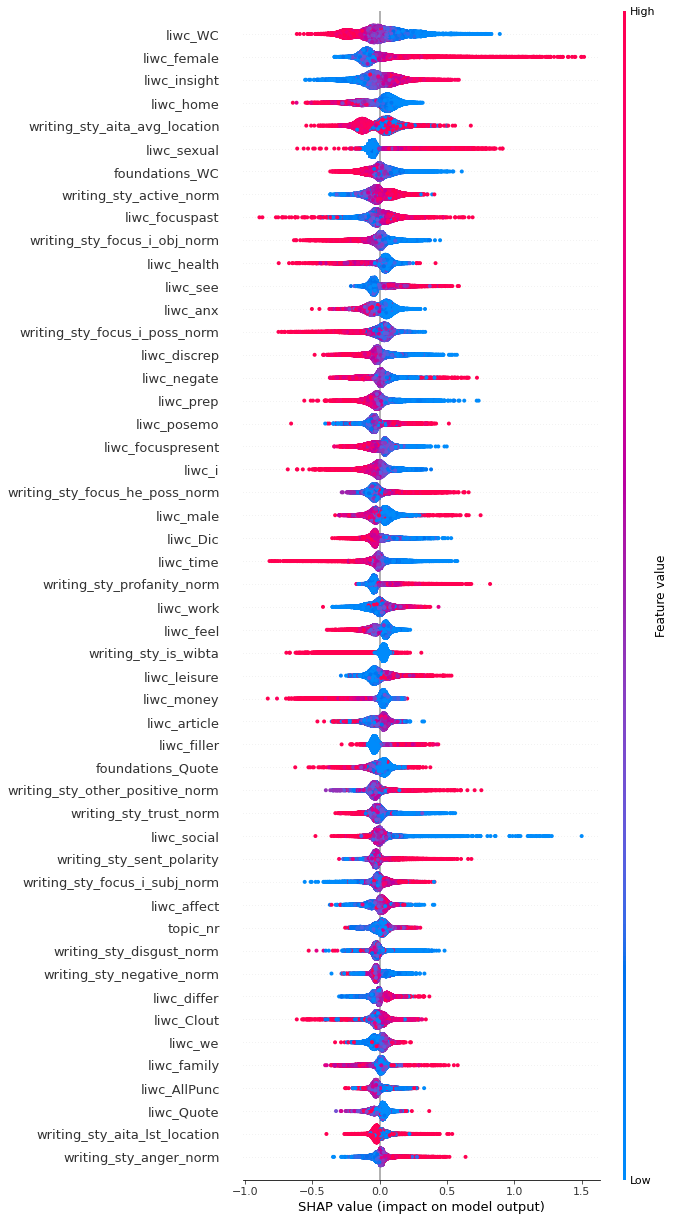

In [ ]:

#explainer = shap.explainers.GPUTree(xgboost, X_train)
explainer = shap.explainers.Tree(xgboost, X_train, feature_names=feat_name_lst)
shap_values = explainer(X_train)
    
shap.summary_plot(shap_values, X_train, feature_names=feat_name_lst, max_display=50)

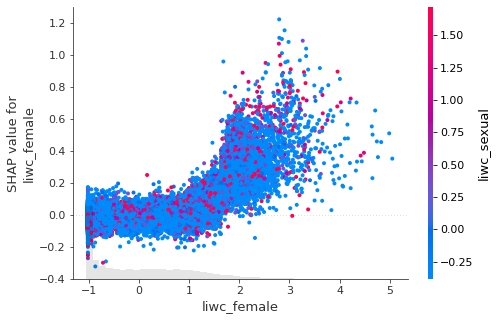

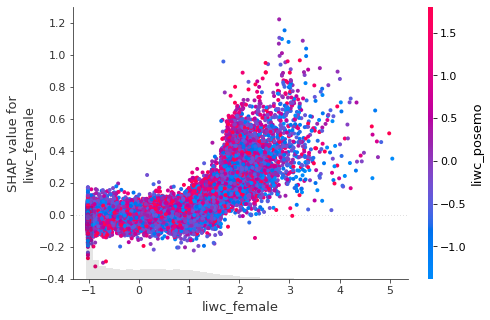

In [ ]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html
shap.plots.scatter(shap_values[:,"liwc_female"], color=shap_values[:,"liwc_male"] )
shap.plots.scatter(shap_values[:,"liwc_female"],color=shap_values )

In [ ]:
# https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a
shap_interaction = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction, X_train, show=False)

NameError: name 'explainer' is not defined